<a href="https://colab.research.google.com/github/KBVKarthik/Keras-Computer-Vision-Models/blob/main/Supervision_Consistency_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install -q tf-models-official tensorflow-addons

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
     |████████████████████████████████| 99 kB 11.1 MB/s 
     |████████████████████████████████| 37.1 MB 46 kB/s 
     |████████████████████████████████| 352 kB 60.6 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 636 kB 58.5 MB/s 
     |████████████████████████████████| 1.2 MB 48.4 MB/s 
     |████████████████████████████████| 211 kB 68.1 MB/s 


In [22]:
from official.vision.image_classification.augment import RandAugment
from tensorflow.keras import layers

import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [23]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5

CROP_TO = 72
RESIZE_TO = 96

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

val_samples = 49500
new_train_x, new_y_train = x_train[: val_samples + 1], y_train[: val_samples + 1]
val_x, val_y = x_train[val_samples:], y_train[val_samples:]

In [25]:
augmenter = RandAugment(num_layers=2, magnitude=9)

In [26]:
def preprocess_train(image, label, noisy=True):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.image.random_crop(image, [CROP_TO, CROP_TO, 3])
    if noisy:
        image = augmenter.distort(image)
    return image, label


def preprocess_test(image, label):
    image = tf.image.resize(image, [CROP_TO, CROP_TO])
    return image, label


train_ds = tf.data.Dataset.from_tensor_slices((new_train_x, new_y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [27]:
train_clean_ds = (
    train_ds.shuffle(BATCH_SIZE * 10, seed=42)
    .map(lambda x, y: (preprocess_train(x, y, noisy=False)), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


train_noisy_ds = (
    train_ds.shuffle(BATCH_SIZE * 10, seed=42)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


consistency_training_ds = tf.data.Dataset.zip((train_clean_ds, train_noisy_ds))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


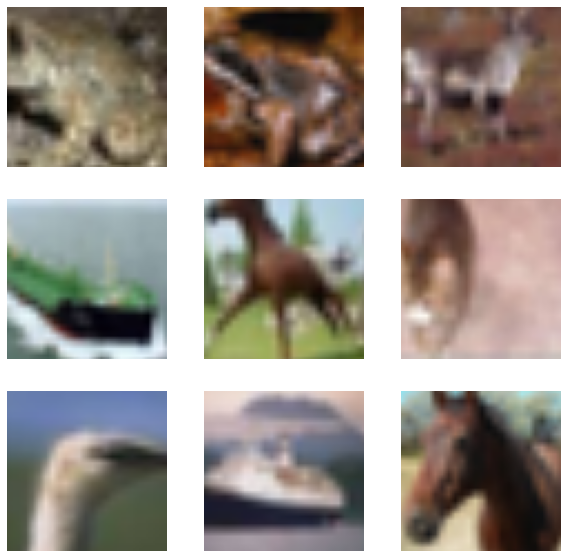

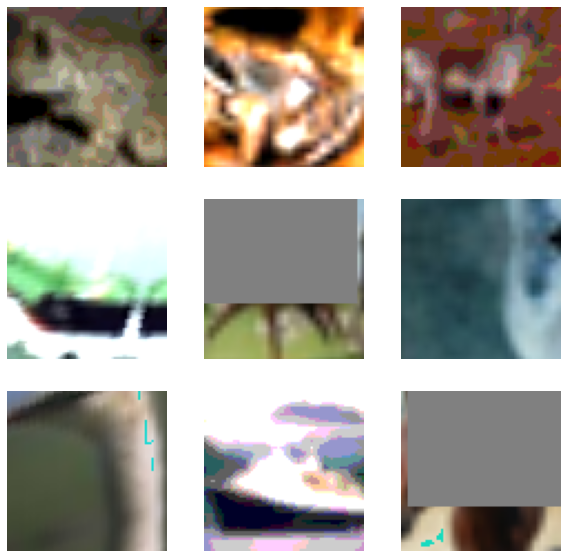

In [28]:
sample_images, sample_labels = next(iter(train_clean_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

sample_images, sample_labels = next(iter(train_noisy_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [29]:
def get_training_model(num_classes=10):
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None, include_top=False, input_shape=(CROP_TO, CROP_TO, 3),
    )
    model = tf.keras.Sequential(
        [
            layers.Input((CROP_TO, CROP_TO, 3)),
            layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes),
        ]
    )
    return model

In [30]:
initial_teacher_model = get_training_model()
initial_teacher_model.save_weights("initial_teacher_model.h5")

In [31]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)


SWA = tfa.optimizers.SWA


teacher_model = get_training_model()
teacher_model.load_weights("initial_teacher_model.h5")
teacher_model.compile(

    optimizer=SWA(tf.keras.optimizers.Adam()),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
history = teacher_model.fit(
    train_clean_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping],
)


_, acc = teacher_model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {acc*100}%")

Epoch 1/5
387/387 [==============================] - 112s 229ms/step - loss: 1.5473 - accuracy: 0.4360 - val_loss: 1.5270 - val_accuracy: 0.4700
Epoch 2/5
387/387 [==============================] - 87s 224ms/step - loss: 1.2092 - accuracy: 0.5698 - val_loss: 1.5381 - val_accuracy: 0.5100
Epoch 3/5
387/387 [==============================] - 87s 224ms/step - loss: 1.0214 - accuracy: 0.6381 - val_loss: 1.8740 - val_accuracy: 0.5200
Epoch 4/5
387/387 [==============================] - 87s 224ms/step - loss: 0.8899 - accuracy: 0.6877 - val_loss: 1.5436 - val_accuracy: 0.5760
Epoch 5/5
387/387 [==============================] - 86s 223ms/step - loss: 0.6524 - accuracy: 0.7726 - val_loss: 0.6633 - val_accuracy: 0.7580
Test accuracy: 74.73999857902527%


In [32]:
class SelfTrainer(tf.keras.Model):
    def __init__(self, student, teacher):
        super(SelfTrainer, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, temperature=3,
    ):
        super(SelfTrainer, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):

        clean_ds, noisy_ds = data
        clean_images, _ = clean_ds
        noisy_images, y = noisy_ds


        teacher_predictions = self.teacher(clean_images, training=False)

        with tf.GradientTape() as tape:

            student_predictions = self.student(noisy_images, training=True)

            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            total_loss = (student_loss + distillation_loss) / 2


        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)


        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


        self.compiled_metrics.update_state(
            y, tf.nn.softmax(student_predictions, axis=1)
        )


        results = {m.name: m.result() for m in self.metrics}
        results.update({"total_loss": total_loss})
        return results

    def test_step(self, data):

        x, y = data


        y_prediction = self.student(x, training=False)


        self.compiled_metrics.update_state(y, tf.nn.softmax(y_prediction, axis=1))


        results = {m.name: m.result() for m in self.metrics}
        return results

In [33]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=3, factor=0.5, monitor="val_accuracy"
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor="val_accuracy"
)


self_trainer = SelfTrainer(student=get_training_model(), teacher=teacher_model)
self_trainer.compile(
    optimizer="adam",
    metrics=["accuracy"],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    temperature=10,
)
history = self_trainer.fit(
    consistency_training_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping],
)


acc = self_trainer.evaluate(test_ds, verbose=0)
print(f"Test accuracy from student model: {acc*100}%")

Epoch 1/5
387/387 [==============================] - 115s 283ms/step - accuracy: 0.2629 - total_loss: 1.0457 - val_accuracy: 0.3660
Epoch 2/5
387/387 [==============================] - 109s 280ms/step - accuracy: 0.3570 - total_loss: 0.9229 - val_accuracy: 0.4340
Epoch 3/5
387/387 [==============================] - 109s 281ms/step - accuracy: 0.4031 - total_loss: 0.8649 - val_accuracy: 0.5040
Epoch 4/5
387/387 [==============================] - 109s 282ms/step - accuracy: 0.4382 - total_loss: 0.8215 - val_accuracy: 0.5080
Epoch 5/5
387/387 [==============================] - 109s 282ms/step - accuracy: 0.4686 - total_loss: 0.7844 - val_accuracy: 0.5240
Test accuracy from student model: 55.21000027656555%
